## Genetski algoritam

Zadatak: Genetskim algoritmom odrediti jednakokraki trougao maksimalne povrsine, upisan u elipsu:

$$ \frac{x^2}{a^2} + \frac{y^2}{b^2} = 1$$
 
Resenje: Dve tacke trougla definisemo, redom, uglovima $\alpha$, $\beta$ koji su u opsegu $[0, 2 \pi)$.

Za dati ugao $\theta$, tacka ce pripadati elipsi ako je

$$ x = a \cos \theta, \quad y = b \sin \theta$$

Treca tacka je definisana time sto trougao treba da bude jednakokraki. 
Ako su poznate koordinate prve dve tacke, tada koordinate trece tacke zadovoljavaju jednacine:

$$ x (x_1 - x_2) + y (y_1 - y_2) = \frac{x_1^2 + y_1^2}{2} + \frac{x_2^2 + y_2^2}{2}$$

$$ x^2 b^2 + y^2a^2 = a^2 b^2$$
 
Uglove cemo da definisemo koriscenjem 12 bita. Prema tome duzina jednog hromozoma je L=24 .

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.stats import rankdata

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Definicija osnovnih parametara algoritma.

N = 50 # broj jedinki u populaciji
L = 36 # duzina hromozoma
pc = 0.9 # verovatnoca ukrstanja
pm = 0.001 # vertovatnoca mutacije
G = 0.8 # procenat populacije koji se menja u narednoj generaciji

## Parametri elipse
a = 15
b = 3
a2 = 15 ** 2
b2 = 3 ** 2

### Osnovne funkcije za crtanje

In [3]:
# Funkcija koja iscrtava elipsu na prosledjenoj figuri.
def plot_elipse(fig, a, b):
    
    theta = np.linspace(0, 2*pi, 200)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    
    plt.figure(fig)
    plt.plot(x, y)

In [4]:
# Funkcija koja iscrtava trouglove na prosledjenoj figuri.
def plot_triangles(fig, X, Y, c, label=''):
    """
   X, Y : N x 3 : one row is one set of points (x1, x2, x3) or (y1, y2, y3)
    c : color
    """
    if X.ndim != Y.ndim:
        return
    
    if X.ndim == 1:
        plt.figure(fig)
        plt.plot([X[0], X[1], X[2], X[0]], 
                 [Y[0], Y[1], Y[2], Y[0]],
                color = c,
                label = label)
        return
    
    if X.shape[0] != Y.shape[0]:
        return
    
    plt.figure(fig)
    for i in range(X.shape[0]):
        plt.plot([X[i][0], X[i][1], X[i][2], X[i][0]], 
                 [Y[i][0], Y[i][1], Y[i][2], Y[i][0]],
                color = c)

In [57]:
# Funkcija koja crta najboljih n trouglova na prosledjenoj figuri.
def plot_best_triangles(fig, fitness, X, Y, n):
    
    if n > fitness.shape[0]:
        n = fitness.shape[0]
        
    ind = np.argsort(-fitness,axis=0)[:n]
    # Najbolji je zeleni, najgori je sivi.
    cmap = plt.cm.get_cmap('Accent', n)
    
    for i in range(n):
        plot_triangles(fig, X[ind[i], :], Y[ind[i], :], c = cmap(i), label = str(round(fitness[ind[i]], 2)))

In [67]:
def plot_base(fig, fitness, X, Y, n):
    
    if n > fitness.shape[0]:
        n = fitness.shape[0]
        
    ind = np.argsort(-fitness,axis=0)[:n]
    # Najbolji je zeleni, najgori je sivi.
    cmap = plt.cm.get_cmap('Accent', n)
    
    plt.figure(fig)
    for i in range(n):
        plt.plot([X[ind[i]][0], X[ind[i]][1], X[ind[i]][0]], 
                 [Y[ind[i]][0], Y[ind[i]][1], Y[ind[i]][0]],
                color = cmap(i),
                linewidth=5)
        print(" i = ", i, "X = ", X[ind[i], :], "Y = ", Y[ind[i], :])
        
        a = np.sqrt(np.power(X[ind[i], 0] - X[ind[i], 1], 2) + np.power(Y[ind[i], 0] - Y[ind[i], 1], 2))
        b = np.sqrt(np.power(X[ind[i], 2] - X[ind[i], 1], 2) + np.power(Y[ind[i], 2] - Y[ind[i], 1], 2))
        c = np.sqrt(np.power(X[ind[i], 0] - X[ind[i], 2], 2) + np.power(Y[ind[i], 0] - Y[ind[i], 2], 2))
        
        print("a = ", a, " b = ", b, " c = ", c)

### Inicijalizacija populacije

In [6]:
def generate_initial_population(N, L):
    population = np.empty((N,),  dtype=object)
    for i in range(N):
        population[i] = ("{0:0"+str(L)+"b}").format(int(np.random.uniform(0,1)*(2 ** L)))
    return population

### Evaluacija populacije i pomocne funkcije za interpretaciju rezultata

In [10]:
def extract_angles(population, L):
    
    N = population.shape[0]
    L = len(population[0])
    
    angles = np.zeros((N, 2))
    clen = L // 2
    for i in range(2):
        angles[:, i] = [int(chrom[i*clen:(i+1)*clen], 2) / (2**clen - 1) * 2 * pi for chrom in population]
    return angles

In [43]:
def eval_area_h(x1, x2, x3, y1, y2, y3):
    
    a = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    b = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    c = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    
    s = (a + b + c) / 2
    
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

In [44]:
def get_third_point(X, Y, a, b):
    """
    X : N x 2 -- one row, one pair of points
    Y : N x 2
    """
    
    A = 2 * a * (X[:, 0] - X[:, 1])
    B = 2 * b * (Y[:, 0] - Y[:, 1])
    C = np.power(X[:, 0], 2) - np.power(X[:, 1], 2) + np.power(Y[:, 0], 2) - np.power(Y[:, 1], 2)
    
    D = np.sqrt(np.power(A, 2) + np.power(B, 2) - np.power(C, 2))
    
    gamma = np.zeros((N, 2))
    gamma[:, 0] = 2 * np.arctan((B - D) / (A + C))
    gamma[:, 1] = 2 * np.arctan((B + D) / (A + C))
    
    X3 = np.zeros((N,))
    Y3 = np.zeros((N,))
    
    # Use point that gives bigger surface.
    for i in range(N):
        
        area1 = eval_area_h(X[i][0], X[i][1], a * np.cos(gamma[i][0]), Y[i][1], Y[i][0], b * np.sin(gamma[i][0]))
        area2 = eval_area_h(X[i][0], X[i][1], a * np.cos(gamma[i][1]), Y[i][1], Y[i][0], b * np.sin(gamma[i][1]))
        
        best = 0
        if area2 > area1:
            best = 1
            
        X3[i] = a * np.cos(gamma[i][best])
        Y3[i] = b * np.sin(gamma[i][best])
    
    return X3, Y3
        
    

In [19]:
def evaluate_area(X, Y):
     
    a = np.sqrt(np.power(X[:, 0] - X[:, 1], 2) + np.power(Y[:, 0] - Y[:, 1], 2))
    b = np.sqrt(np.power(X[:, 2] - X[:, 1], 2) + np.power(Y[:, 2] - Y[:, 1], 2))
    c = np.sqrt(np.power(X[:, 0] - X[:, 2], 2) + np.power(Y[:, 0] - Y[:, 2], 2))
    
    s = (a + b + c) / 2
    
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

In [45]:
def evaluate_population(population, a, b):
    
    N = population.shape[0]
    L = len(population[0])
    X = np.zeros((N, 3))
    Y = np.zeros((N, 3))
    
    angles = extract_angles(population, L)
    
    for i in range(2):
        X[:, i] = a * np.cos(angles[:, i])
        Y[:, i] = b * np.sin(angles[:, i])
        
    X3, Y3 = get_third_point(X[:, 0:2], Y[:, 0:2], a, b)
    
    X[:, 2] = X3
    Y[:, 2] = Y3
        
    return evaluate_area(X, Y), X, Y

 i =  0 X =  [ 12.74833356 -12.10390212   0.28626673] Y =  [-1.58088572 -1.77195433  2.99945363]
a =  24.85297015230658  b =  13.277146457965108  c =  13.27714645796511
 i =  1 X =  [-11.11946406  14.6240901    1.52616614] Y =  [ 2.01352943  0.66741258 -2.98443172]
a =  25.778724002829307  b =  13.597484280781094  c =  13.597484280781092
 i =  2 X =  [ 10.25514731 -14.85418777  -1.99770259] Y =  [-2.18935565 -0.41728195  2.97327553]
a =  25.171788842130383  b =  13.29605547880622  c =  13.296055478806215
 i =  3 X =  [-8.53967071 13.27993772  2.12950257] Y =  [-2.46636594 -1.39489432  2.96961424]
a =  21.845900377617248  b =  11.974186361452094  c =  11.974186361452096
 i =  4 X =  [-9.88048618 10.83776927  0.43298497] Y =  [-2.25721947 -2.07405648  2.9987499 ]
a =  20.719065069417024  b =  11.575530267374628  c =  11.575530267374631
 i =  5 X =  [-8.46740372 14.50059208  2.67633423] Y =  [-2.47631237 -0.76766736  2.95186202]
a =  23.031463234156405  b =  12.395481943818618  c =  12.39

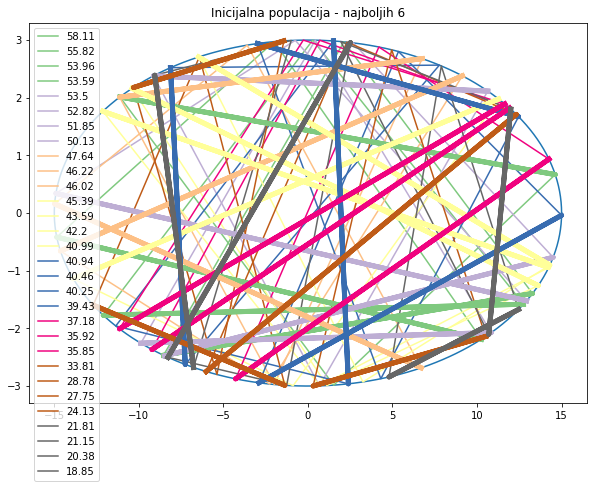

In [69]:
population = generate_initial_population(50, 32)
area, X, Y = evaluate_population(population, a, b)
plt.figure("init", figsize = (10, 7))
plt.title('Inicijalna populacija - najboljih 6')
plot_elipse("init", a, b)
plot_best_triangles("init", area, X, Y, 30)
plot_base("init", area, X, Y, 30)
_ = plt.legend(loc="best")

0.0